<a href="https://colab.research.google.com/github/esantonati-lab/PhiUSIIL_Phishing_URL/blob/main/Codice_AI2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Import

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from mpl_toolkits.mplot3d import Axes3D

###Library

In [27]:
#Vectorized sigmoid function
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

#Logistic Regression Cost Function
def logistic_cost(theta, x, y):
    theta = np.matrix(theta).T
    x = np.matrix(x)
    y = np.matrix(y)
    h = sigmoid(x * theta)
    h = np.clip(h, 1e-10, 1 - 1e-10) # Clipping per stabilità
    first = np.multiply(-y, np.log(h))
    second = np.multiply((1 - y), np.log(1 - h))
    return np.sum(first - second) / (len(x))

#Logistic Regression Cost Gradient
def cost_gradient(theta, x, y):
    theta = np.matrix(theta).T
    x = np.matrix(x)
    y = np.matrix(y)
    error = sigmoid(x * theta) - y
    grad = np.array(np.sum(np.multiply(error, x), axis=0) / len(x)).flatten()
    return grad

def predict(theta, x, threshold=0.5):
    theta = np.matrix(theta).T
    probabilities = sigmoid(x * theta)
    return [1 if p >= threshold else 0 for p in probabilities]

###College Dataset

In [28]:
#Caricamento e pulizia dei dati
dataset_path = "/content/drive/MyDrive/progetto_ai/PhiUSIIL_Phishing_URL_Dataset.csv"
df = pd.read_csv(dataset_path)

df_numeric = df.select_dtypes(include=[np.number])

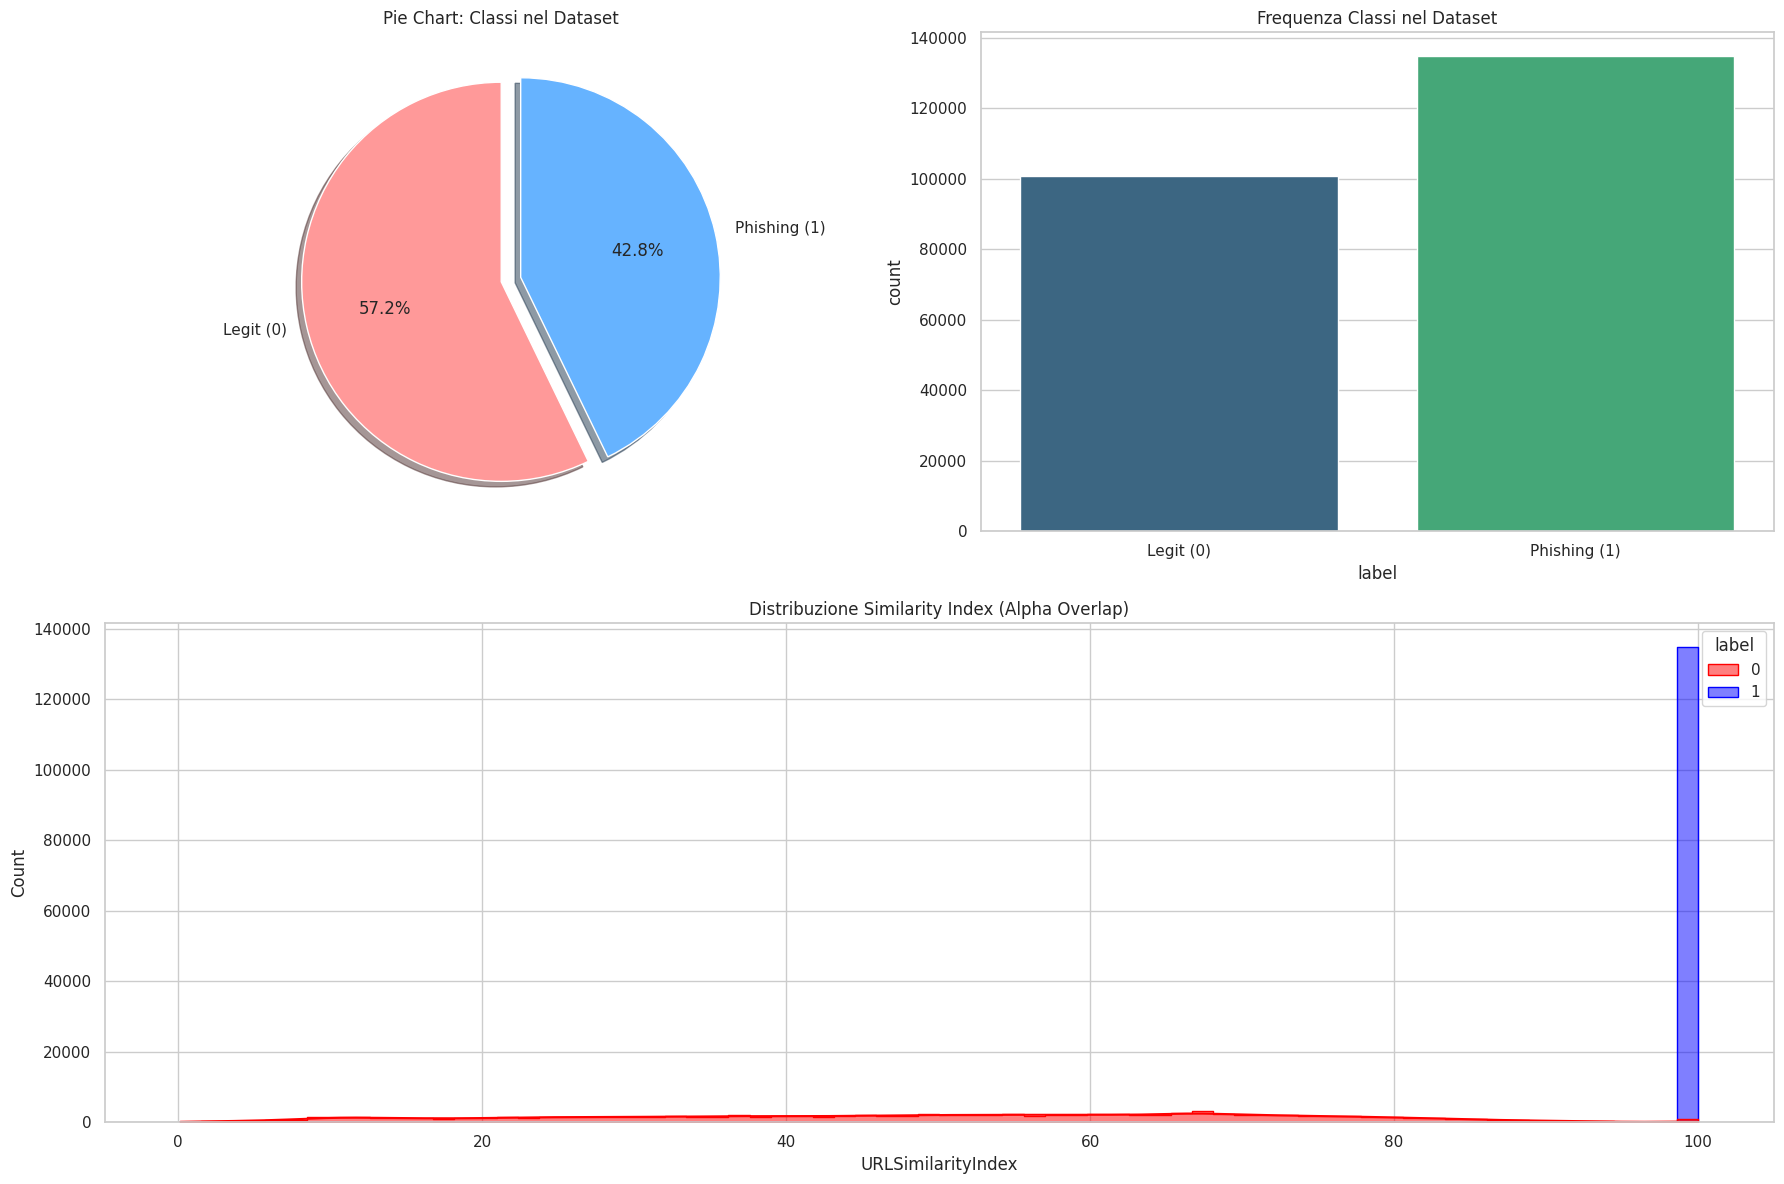

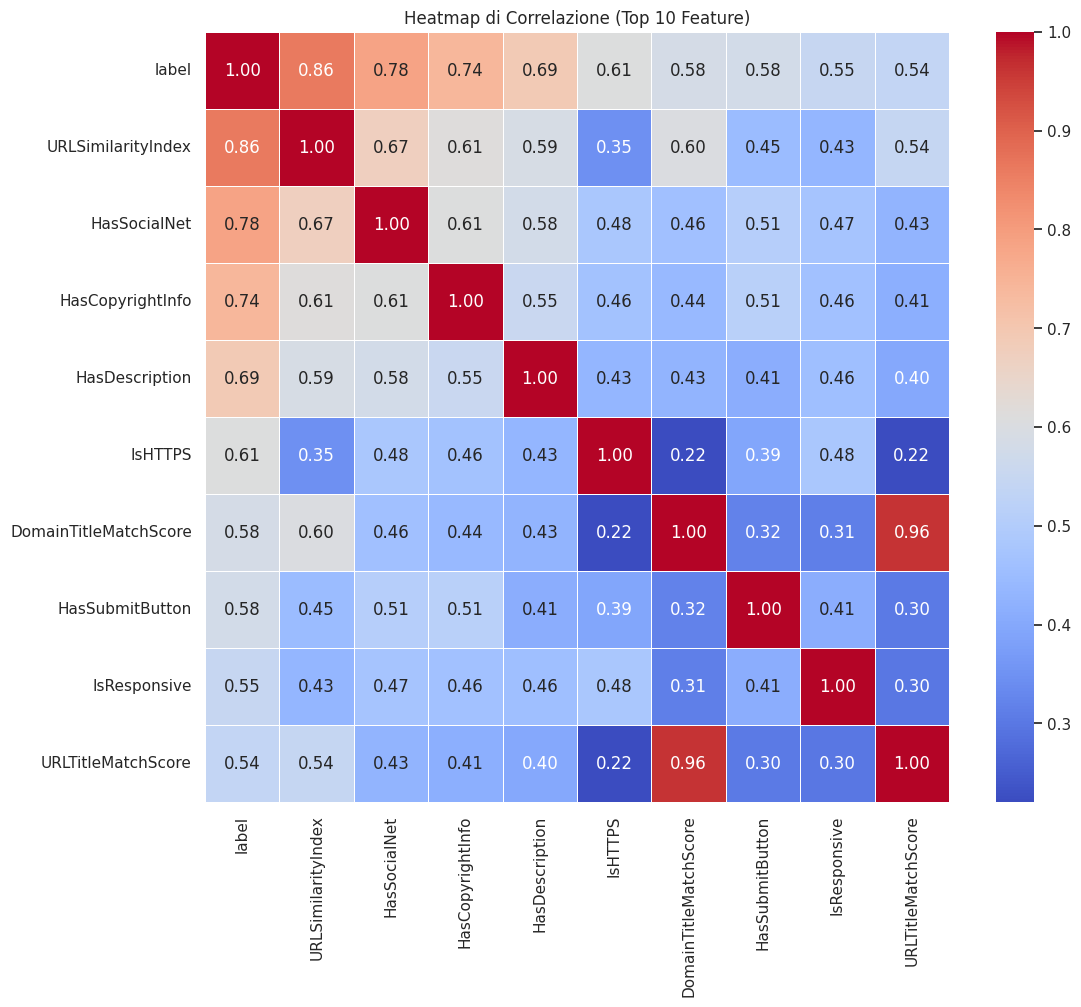

In [29]:
#Analisi Esplorativa dei Dati (EDA)
fig = plt.figure(figsize=(18, 12))

#Pie Chart della distribuzione classi
ax1 = plt.subplot2grid((2, 2), (0, 0))
class_counts = df['label'].value_counts()
ax1.pie(class_counts, labels=['Legit (0)', 'Phishing (1)'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=90, explode=(0, 0.1), shadow=True)
ax1.set_title("Pie Chart: Classi nel Dataset")

#Istogramma della distribuzione delle classi
ax2 = plt.subplot2grid((2, 2), (0, 1))
sns.countplot(x='label', data=df, hue='label', palette='viridis', ax=ax2, legend=False)
ax2.set_title('Frequenza Classi nel Dataset')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Legit (0)', 'Phishing (1)'])

#Distribuzione Similarity Index
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
sns.histplot(data=df, x='URLSimilarityIndex', hue='label', kde=True, element="step", alpha=0.5, palette=['red', 'blue'], ax=ax3, common_norm=False)
ax3.set_title("Distribuzione Similarity Index (Alpha Overlap)")

plt.tight_layout()
plt.show()

#Heatmap di Correlazione
plt.figure(figsize=(12, 10))
top_features = df_numeric.corr()['label'].sort_values(ascending=False).head(10).index
sns.heatmap(df_numeric[top_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap di Correlazione (Top 10 Feature)")
plt.show()


In [30]:
#Preprocessing e feature engineering
features = ['URLSimilarityIndex', 'NoOfSelfRef', 'NoOfExternalRef']
X_raw = df_numeric[features].values
Y = df_numeric['label'].values.reshape(-1, 1)

#Scaling Z-score
X_mean, X_std = np.mean(X_raw, axis=0), np.std(X_raw, axis=0)
X_scaled = (X_raw - X_mean) / X_std
X_final = np.concatenate((np.ones((len(X_scaled), 1)), X_scaled), axis=1)

#Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_final, Y, test_size=0.2, random_state=42)

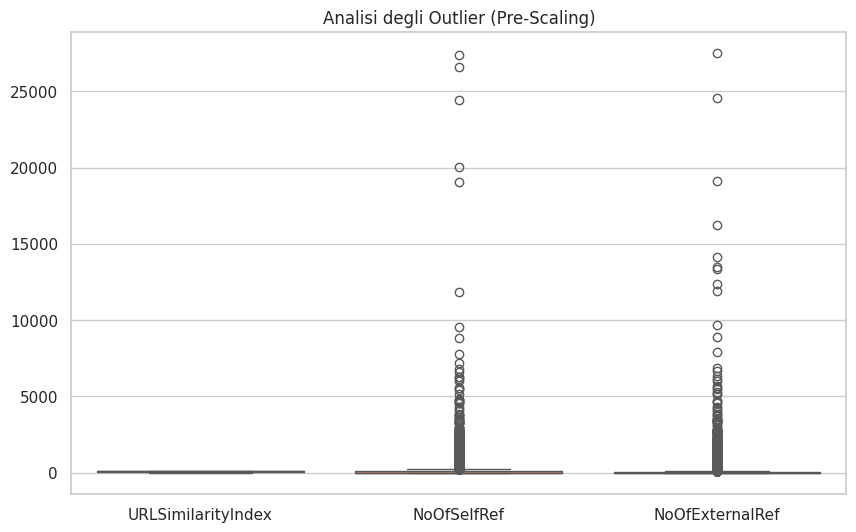

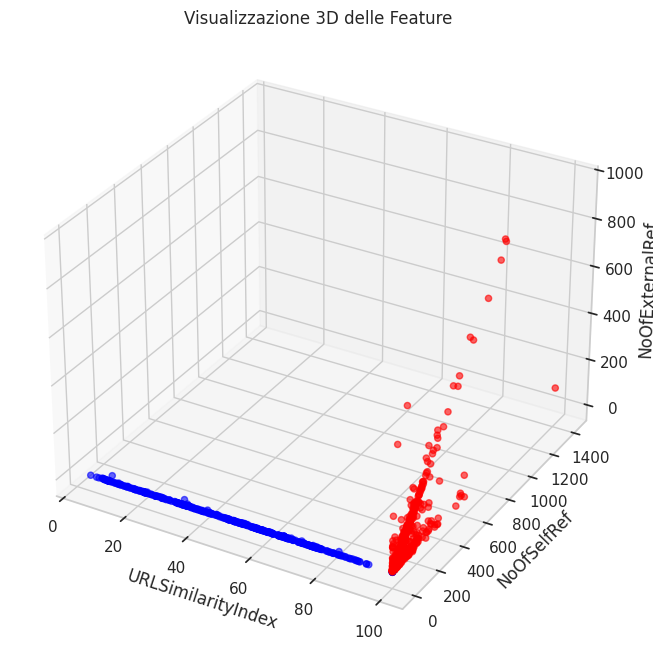

In [31]:
#Boxplot Outlier
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[features], palette="Set2")
plt.title("Analisi degli Outlier (Pre-Scaling)")
plt.show()

#Scatter Plot 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sample = df.sample(1000, random_state=1)
ax.scatter(sample[features[0]], sample[features[1]], sample[features[2]], c=sample['label'], cmap='bwr', alpha=0.6)
ax.set_xlabel(features[0]); ax.set_ylabel(features[1]); ax.set_zlabel(features[2])
ax.set_title("Visualizzazione 3D delle Feature")
plt.show()

In [32]:
#Addestramento del modello
initial_theta = np.zeros(X_train.shape[1])
result = opt.fmin_tnc(func=logistic_cost, x0=initial_theta, fprime=cost_gradient, args=(X_train, y_train))
theta_opt = result[0]

#Calcolo accuratezza
y_pred_custom = predict(theta_opt, X_test)
accuracy_custom = np.mean([1 if a == b else 0 for (a, b) in zip(y_pred_custom, y_test.flatten())])

#confronto con SCIKIT-LEARN
logreg_sklearn = linear_model.LogisticRegression(C=1e5, solver='liblinear')
logreg_sklearn.fit(X_train[:, 1:], y_train.ravel())
accuracy_sklearn = logreg_sklearn.score(X_test[:, 1:], y_test.ravel())

print("\n" + "="*40)
print(f"Risultati finali sul test set")
print(f"Accuratezza Modello: {accuracy_custom * 100:.2f}%")
print(f"Accuratezza Scikit-Learn:   {accuracy_sklearn * 100:.2f}%")
print(f"Differenza:                 {(accuracy_custom - accuracy_sklearn)*100:.4f}%")
print("="*40)

print("\nReport di Classificazione Dettagliato:")
print(classification_report(y_test, y_pred_custom))


Risultati finali sul test set
Accuratezza Modello: 99.83%
Accuratezza Scikit-Learn:   99.67%
Differenza:                 0.1569%

Report di Classificazione Dettagliato:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20124
           1       1.00      1.00      1.00     27035

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



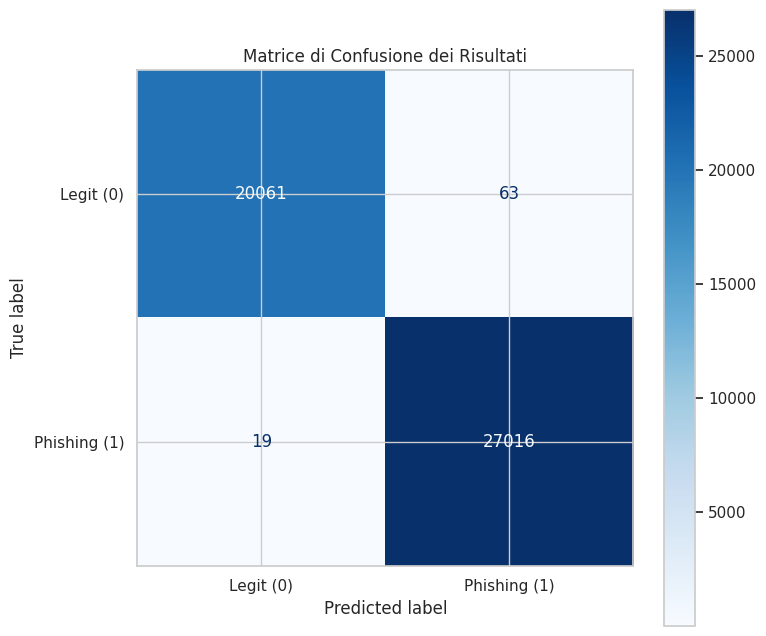

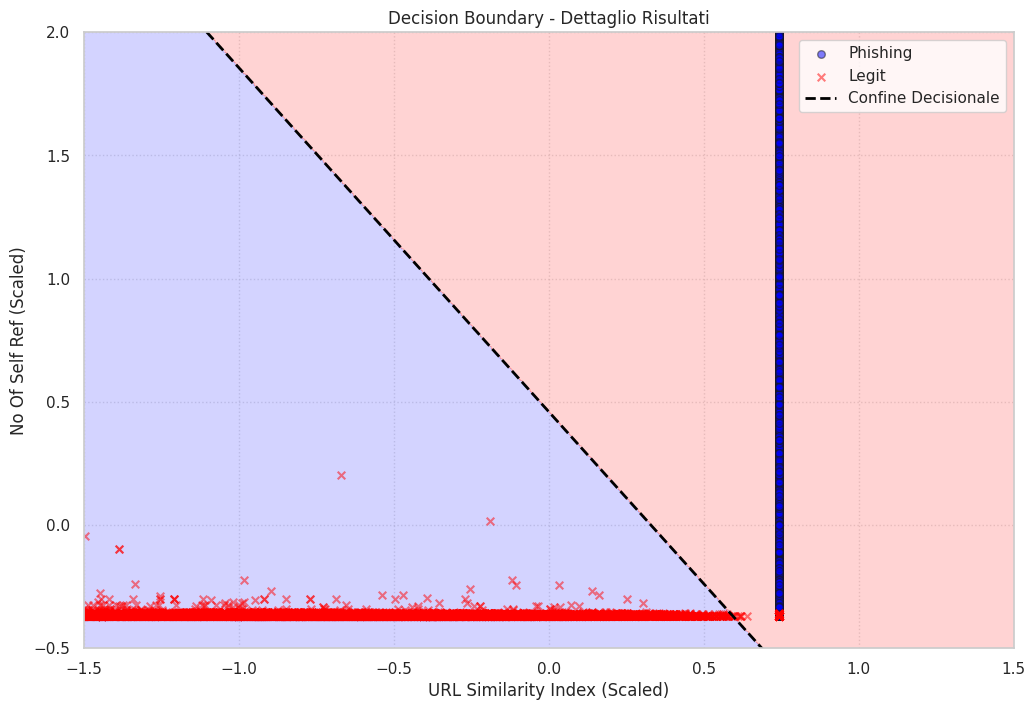

In [34]:
#Matrice di Confusione
cm = confusion_matrix(y_test, y_pred_custom)
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legit (0)', 'Phishing (1)'])
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Matrice di Confusione dei Risultati')
plt.show()

#Decision Boundary
X_plot_train = X_train[:, 1:3]
logreg_2d = linear_model.LogisticRegression().fit(X_plot_train, y_train.ravel())

x_z_min, x_z_max = -1.5, 1.5
y_z_min, y_z_max = -0.5, 2.0
xx, yy = np.meshgrid(np.linspace(x_z_min, x_z_max, 500), np.linspace(y_z_min, y_z_max, 500))
Z = logreg_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.2, cmap='bwr')

X_plot_test = X_test[:, 1:3]
plt.scatter(X_plot_test[y_test.ravel()==1, 0], X_plot_test[y_test.ravel()==1, 1], c='blue', s=30, label='Phishing', alpha=0.5, edgecolors='k')
plt.scatter(X_plot_test[y_test.ravel()==0, 0], X_plot_test[y_test.ravel()==0, 1], c='red', s=30, marker='x', label='Legit', alpha=0.5)

b = logreg_2d.intercept_[0]
w1, w2 = logreg_2d.coef_[0]
x_line = np.linspace(x_z_min, x_z_max, 100)
y_line = -(w1 * x_line + b) / w2
plt.plot(x_line, y_line, color='black', linestyle='--', linewidth=2, label='Confine Decisionale')

plt.xlim(x_z_min, x_z_max); plt.ylim(y_z_min, y_z_max)
plt.xlabel('URL Similarity Index (Scaled)'); plt.ylabel('No Of Self Ref (Scaled)')
plt.title('Decision Boundary - Dettaglio Risultati')
plt.legend(); plt.grid(True, linestyle=':', alpha=0.6)
plt.show()